![](../img/330-banner.png)

# Lecture 7: Linear Models


UBC 2022-23

Instructor: Giulia Toti

## Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("../code/.")
from plotting_functions import *
from utils import *
from ipywidgets import interact, interactive
import ipywidgets as widgets

pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

## Learning outcomes

From this lecture, students are expected to be able to: 

- Explain the general intuition behind linear models;
- Explain how `predict` works for linear regression;
- Use `scikit-learn`'s `Ridge` model; 
- Demonstrate how the `alpha` hyperparameter of `Ridge` is related to the fundamental tradeoff; 
- Explain the difference between linear regression and logistic regression;   
- Use `scikit-learn`'s `LogisticRegression` model and `predict_proba` to get probability scores
- Explain the advantages of getting probability scores instead of hard predictions during classification; 
- Broadly describe linear SVMs 
- Explain how can you interpret model predictions using coefficients learned by a linear model; 
- Explain the advantages and limitations of linear classifiers 

<br><br>

## Linear models [[video](https://youtu.be/HXd1U2q4VFA)]

**Linear models** is a fundamental and widely used class of models. They are called **linear** because they make a prediction using a **linear function** of the input features.  

We will talk about three linear models: 
- Linear regression 
- Logistic regression
- Linear SVM (brief mention)

### Linear regression 

- A very popular statistical model and has a long history.  
- Imagine a hypothetical regression problem of predicting weight of a snake given its length. 

In [2]:
np.random.seed(7)
n = 100
X_1 = np.linspace(0, 2, n) + np.random.randn(n) * 0.01
X = pd.DataFrame(X_1[:, None], columns=["length"])
# Return evenly spaced numbers over a specified interval.
# Returns num evenly spaced samples, calculated over the interval [start, stop].

y = abs(np.random.randn(n, 1)) * 3 + X_1[:, None] * 5 + 0.2
# randn generates an array of shape (d0, d1, ..., dn), 
# filled with random floats sampled from a univariate “normal” 
# (Gaussian) distribution of mean 0 and variance 1
y = pd.DataFrame(y, columns=["weight"])
snakes_df = pd.concat([X, y], axis=1)
train_df, test_df = train_test_split(snakes_df, test_size=0.2, random_state=77)

X_train = train_df[["length"]]
y_train = train_df["weight"]
X_test = test_df[["length"]]
y_test = test_df["weight"]
train_df.head()

,length,weight
73,1.489130,10.507995
53,1.073233,7.658047
80,1.622709,9.748797
49,0.984653,9.731572
23,0.484937,3.016555


Let's visualize the hypothetical snake data. 

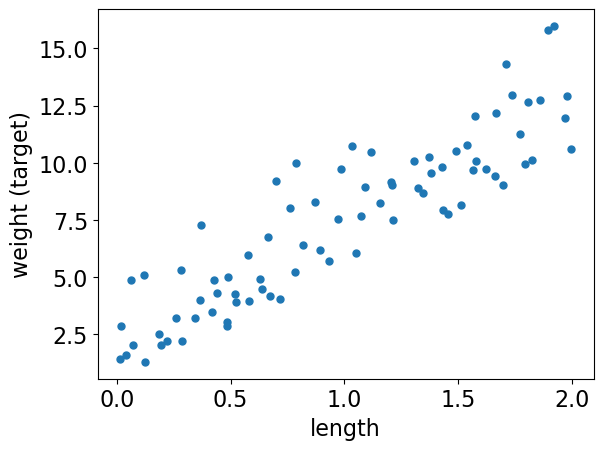

In [3]:
plt.plot(X_train, y_train, ".", markersize=10)
plt.xlabel("length")
plt.ylabel("weight (target)");

Let's plot a linear regression model on this dataset. 

In [4]:
grid = np.linspace(min(X_train.to_numpy())[0], max(X_train.to_numpy())[0], 1000)
grid = grid.reshape(-1, 1)

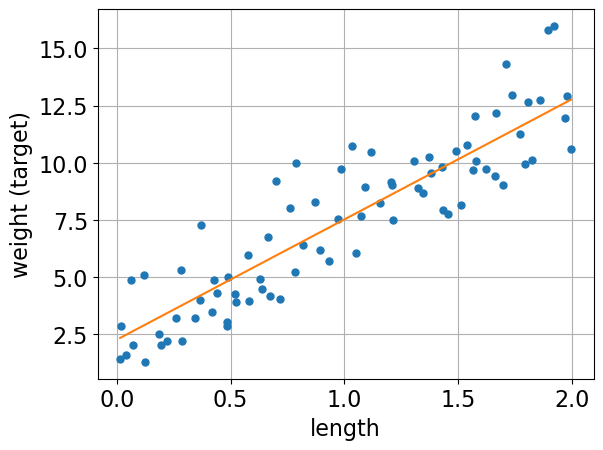

In [5]:
from sklearn.linear_model import Ridge

r = Ridge()
r.fit(X_train, y_train)
plt.plot(X_train, y_train, ".", markersize=10)
plt.plot(grid, r.predict(grid))
plt.grid(True)
plt.xlabel("length")
plt.ylabel("weight (target)");

**The orange line is the learned linear model.**

### Prediction of linear regression

- Given a snake length, we can use the model above to predict the target (i.e., the weight of the snake). 
- The prediction will be the corresponding weight on the orange line. 

In [6]:
snake_length = 0.75
r.predict([[snake_length]])

array([6.20683258])

#### What are we exactly learning? 

- The model above is a line, which can be represented with a slope (i.e., coefficient or weight) and an intercept. 
- For the above model, we can access the slope (i.e., coefficient or weight) and the intercept using `coef_` and `intercept_`, respectively. 

In [7]:
r.coef_  # r is our linear regression object

array([5.26370005])

In [8]:
r.intercept_  # r is our linear regression object

2.259057547817185

### How are we making predictions? 
- Given a feature value $x_1$ and learned coefficient $w_1$ and intercept $b$, we can get the prediction $\hat{y}$ with the following formula:
$$\hat{y} = w_1x_1 + b$$

In [9]:
prediction = snake_length * r.coef_ + r.intercept_
prediction

array([6.20683258])

In [10]:
r.predict([[snake_length]])

array([6.20683258])

Great! Now we exactly know how the model is making the prediction. 

### Generalizing to more features
For more features, the model is a higher dimensional hyperplane and the general prediction formula looks as follows: 

$\hat{y} =$ <font color="red">$w_1$</font> <font color="blue">$x_1$ </font> $+ \dots +$ <font color="red">$w_d$</font> <font color="blue">$x_d$</font> + <font  color="green"> $b$</font>

where, 
- <font  color="blue"> ($x_1, \dots, x_d$) are input features </font>
- <font  color="red"> ($w_1, \dots, w_d$) are coefficients or weights </font> (learned from the data)
- <font  color="green"> $b$ is the bias which can be used to offset your hyperplane </font> (learned from the data)

### Example 

- Suppose these are the coefficients learned by a linear regression model on a hypothetical housing price prediction dataset. 

| Feature | Learned coefficient |
|--------------------|---------------------:|
| Bedrooms | 0.20 |
| Bathrooms| 0.11 |
| Square Footage | 0.002 |
| Age | -0.02 |

- Now given a new example, the target will be predicted as follows: 
| Bedrooms | Bathrooms | Square Footage | Age |
|--------------------|---------------------|----------------|-----| 
| 3                  | 2                   | 1875           | 66  |

$$\hat{y} = w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + b$$

$$\text{predicted price}=  0.20 \times 3 + 0.11 \times 2 + 0.002 \times 1875 + (-0.02) \times 66 + b$$

When we call `fit`, a coefficient or weight is learned for each feature which tells us the role of that feature in prediction. These coefficients are learned from the training data.  

```{important}
In linear models for regression, the model is a line for a single feature, a plane for two features, and a hyperplane for higher dimensions. We are not yet ready to discuss how does linear regression learn these coefficients and intercept.
```

### `Ridge`

- `scikit-learn` has a model called `LinearRegression` for linear regression. 
- But if we use this "vanilla" version of linear regression, it may result in large coefficients and unexpected results. -> very real risk of this happening
- So instead of using `LinearRegression`, we will always use another linear model called `Ridge`, which is a linear regression model with a complexity hyperparameter `alpha`.
- If you want to know more about how Ridge regularization works, I recommend this tutorial: https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

In [11]:
from sklearn.linear_model import LinearRegression  # DO NOT USE IT
from sklearn.linear_model import Ridge  # USE THIS INSTEAD

#### Data

Let's use `sklearn`'s built in regression dataset, the Boston Housing dataset. The task associated with this dataset is to predict the median value of homes in several Boston neighborhoods in the 1970s, using information such as crime rate in the neighbourhood, average number of rooms, proximity to the Charles River, highway accessibility, and so on.

In [12]:
from sklearn.datasets import load_boston

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, test_size=0.2
)
pd.DataFrame(X_train, columns=boston.feature_names)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,5.20177,0.0,18.10,1.0,0.770,6.127,83.4,2.7227,24.0,666.0,20.2,395.43,11.48
1,0.17142,0.0,6.91,0.0,0.448,5.682,33.8,5.1004,3.0,233.0,17.9,396.90,10.21
2,0.09378,12.5,7.87,0.0,0.524,5.889,39.0,5.4509,5.0,311.0,15.2,390.50,15.71
3,0.09252,30.0,4.93,0.0,0.428,6.606,42.2,6.1899,6.0,300.0,16.6,383.78,7.37
4,0.01432,100.0,1.32,0.0,0.411,6.816,40.5,8.3248,5.0,256.0,15.1,392.90,3.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.51183,0.0,6.20,0.0,0.507,7.358,71.6,4.1480,8.0,307.0,17.4,390.07,4.73
400,23.64820,0.0,18.10,0.0,0.671,6.380,96.2,1.3861,24.0,666.0,20.2,396.90,23.69
401,0.04819,80.0,3.64,0.0,0.392,6.108,32.0,9.2203,1.0,315.0,16.4,392.89,6.57
402,1.27346,0.0,19.58,1.0,0.605,6.250,92.6,1.7984,5.0,403.0,14.7,338.92,5.50


In [13]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

#### `Ridge` on the Boston housing dataset

In [14]:
pipe = make_pipeline(StandardScaler(), Ridge())
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.004578,0.000521,0.743230,0.766721
1,0.001105,0.000387,0.787715,0.757490
2,0.000863,0.000334,0.758903,0.761349
3,0.000831,0.000332,0.775489,0.753837
4,0.000855,0.000338,0.644863,0.788461


#### Hyperparameter `alpha` of `Ridge`

- Ridge has hyperparameters just like the rest of the models we learned.
- The alpha hyperparameter is what makes `Ridge` different from vanilla `LinearRegression`. 
- Similar to the other hyperparameters that we saw, `alpha` controls the fundamental tradeoff. 

```{note}
If we set alpha=0 that is the same as using LinearRegression.
```

Let's examine the effect of `alpha` on the fundamental tradeoff. 

In [15]:
scores_dict = {
    "alpha": 10.0 ** np.arange(-2, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
print(scores_dict["alpha"])
for alpha in scores_dict["alpha"]:
    pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    scores = cross_validate(pipe_ridge, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]


In [16]:
results_df

,alpha,mean_train_scores,mean_cv_scores
0,0.01,0.765604,0.741829
1,0.10,0.765603,0.741851
2,1.00,0.765572,0.742040
3,10.00,0.763671,0.741906
4,100.00,0.731996,0.718132
5,1000.00,0.527530,0.522510
6,10000.00,0.155124,0.148313
7,100000.00,0.019292,0.010749


Here we do not really see overfitting but in general, 
- larger `alpha` $\rightarrow$ likely to underfit
- smaller `alpha` $\rightarrow$ likely to overfit

#### Coefficients and intercept

The model learns 
- coefficients associated with each feature
- the intercept or bias

Let's examine the coefficients learned by the model. 

In [17]:
pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
pipe_ridge.fit(X_train, y_train)
coeffs = pipe_ridge.named_steps["ridge"].coef_

In [18]:
pd.DataFrame(data=coeffs, index=boston.feature_names, columns=["Coefficients"])

,Coefficients
CRIM,-0.923517
ZN,1.431294
INDUS,0.239976
CHAS,0.546769
NOX,-2.048052
RM,2.668174
AGE,0.035459
DIS,-3.084434
RAD,2.407602
TAX,-2.269648


- The model also learns an intercept (bias). 
- For each prediction, we are adding this amount irrespective of the feature values.  

In [19]:
pipe_ridge.named_steps["ridge"].intercept_

22.446534653465363

Can we use this information to interpret model predictions? 

### ❓❓ Questions for you

#### True/False: `Ridge`

1. Increasing the hyperparameter `alpha` of `Ridge` is likely to decrease model complexity.
Alpha increases the rigidity of the model -> learn less -> decrease model complexity
smaller alpha -> overfit -> more complex
larger alpha -> underfit -> less complex  
higher alpha -> more coefficients of features can be flattened to zero (eliminating bad features)
2. `Ridge` can be used with datasets that have multiple features.  
True.
3. With Ridge, we learn one coefficient per training example.  
False. We learn one coefficient per feature.  
4. If you train a linear regression model on a 2-dimensional problem (2 features), the model will be a two dimensional plane.
2 features + target -> 3 dimensional problem 
model is a 2-d plane

https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/

<br><br><br><br>

## Interpretation of coefficients 

- One of the main advantages of linear models is that they are relatively easy to interpret. 
- We have one coefficient per feature which kind of describes the role of the feature in the prediction according to the model. 

There are two pieces of information in the coefficients based on

- Sign
- Magnitude

### Sign of the coefficients

In the example below, for instance: 
- RM (average number of rooms) has a **positive coefficient**
    - the prediction will be proportional to the feature value; as RM gets **bigger**, the median house value gets **bigger** 
- CRIM (criminal rate in the neighbourhood) has a **negative coefficient**
    - the prediction will be inversely proportional to the feature value; as CRIM gets **bigger**, the median house value gets **smaller**

In [20]:
pd.DataFrame(data=coeffs, index=boston.feature_names, columns=["Coefficients"])

,Coefficients
CRIM,-0.923517
ZN,1.431294
INDUS,0.239976
CHAS,0.546769
NOX,-2.048052
RM,2.668174
AGE,0.035459
DIS,-3.084434
RAD,2.407602
TAX,-2.269648


#### Magnitude of the coefficients

- Bigger magnitude $\rightarrow$ bigger impact on the prediction 
- In the example below, both RM and AGE have a positive impact on the prediction but RM would have a bigger positive impact because it's feature value is going to be multiplied by a number with a bigger magnitude. 
- Similarly both LSAT and NOX have a negative impact on the prediction but LSAT would have a bigger negative impact because it's going to be multiplied by a number with a bigger magnitude. 
- increasing bedrooms will have a bigger impact that increasing square feet of apartment for example
- if coefficient is close to zero, that feature does not have any impact or has little impact on the output.

In [21]:
data = {
    "coefficient": pipe_ridge.named_steps["ridge"].coef_.tolist(),
    "magnitude": np.absolute(pipe_ridge.named_steps["ridge"].coef_.tolist()),
}
coef_df = pd.DataFrame(data, index=boston.feature_names).sort_values(
    "magnitude", ascending=False
)
coef_df

,coefficient,magnitude
LSTAT,-3.394533,3.394533
DIS,-3.084434,3.084434
RM,2.668174,2.668174
RAD,2.407602,2.407602
TAX,-2.269648,2.269648
NOX,-2.048052,2.048052
PTRATIO,-1.883905,1.883905
ZN,1.431294,1.431294
CRIM,-0.923517,0.923517
B,0.897462,0.897462


### Importance of scaling 
- When you are interpreting the model coefficients, scaling is crucial. 
- If you do not scale the data, features with smaller magnitude are going to get coefficients with bigger magnitude whereas features with bigger scale are going to get coefficients with smaller magnitude.
- That said, when you scale the data, feature values become hard to interpret for humans!

```{Important}
Take these coefficients with a grain of salt. They might not always match your intuitions.  
```

### ❓❓ Questions for you

#### True/False

1. Suppose you have trained a linear model on an unscaled data. The coefficients of the linear model have the following interpretation: if coefficient $j$ is large, that means a change in feature $j$ has a large impact on the prediction.
True, it still has a large impact. But it doesn't mean that it is more IMPORTANT.
eg. y = 20xsqf + 40000xnumberOfRooms
they are not scaled, but one unit change of rooms has larger impact than 1 unit change of sqf
eg. weight = b + ___ x length 
if length is in metres -> 1m snake vs 2m snake -> 2m snake will be much heavier
if length is in millimetres -> 1000mm snake vs 1001mm snake -> impact on weight is not great.  
to see if a feature is more important or not -> need to scale it first -> the one with large coefficient is more important
2. Suppose the scaled feature value of NOX feature above is negative. The prediction will still be inversely proportional to NOX; as NOX gets **bigger**, the median house value gets **smaller**. 
ie. will there be a change in sign of coefficient if scaled or not scaled?
Ans: no change.

#### Questions for breakout room discussion 

- Discuss the importance of scaling when interpreting linear regression coefficients. 
- What might be the meaning of complex vs simpler model in case of linear regression? 

<br><br><br><br>

## Logistic regression [[video](https://youtu.be/56L5z_t22qE)]

### Logistic regression intuition 

- A linear model for **classification**. 
- Similar to linear regression, it learns weights associated with each feature and the bias. 
- It applies a **threshold** on the raw output to decide whether the class is positive or negative. 
- In this lecture we will focus on the following aspects of logistic regression.  
    - `predict`, `predict_proba` 
    - how to use learned coefficients to interpret the model

### Motivating example 

- Consider the problem of predicting sentiment expressed in movie reviews. 

#### Training data for the motivating example


<blockquote> 
    <p>Review 1: This movie was <b>excellent</b>! The performances were oscar-worthy!  👍 </p> 
    <p>Review 2: What a <b>boring</b> movie! I almost fell asleep twice while watching it. 👎 </p> 
    <p>Review 3: I enjoyed the movie. <b>Excellent</b>! 👍 </p>             
</blockquote>  

- Targets: positive 👍 and negative 👎
- Features: words (e.g., *excellent*, *flawless*, *boring*)


#### Learned coefficients associated with all features

- Suppose our vocabulary contains only the following 7 words. 
- A linear classifier learns **weights** or **coefficients** associated with the features (words in this example).  
- Let's ignore bias for a bit. 

<center>
<img src='../img/words_coeff.png' width="250" height="300" />
</center>  


#### Predicting with learned weights 
- Use these learned coefficients to make predictions. For example, consider the following review $x_i$. 
<blockquote> 
It got a bit <b>boring</b> at times but the direction was <b>excellent</b> and the acting was <b>flawless</b>.
</blockquote>
- Feature vector for $x_i$: [1, 0, 1, 1, 0, 0, 0]

<center>
<img src='../img/words_coeff.png' width="250" height="300" />
</center>  

- $score(x_i) = $ coefficient(*boring*) $\times 1$ + coefficient(*excellent*) $\times 1$ + coefficient(*flawless*) $\times 1$ = $-1.40 + 1.93 + 1.43 = 1.96$

- $1.96 > 0$ so predict the review as positive 👍. 

Weighted sum of the input features = 1.960 y_hat = pos


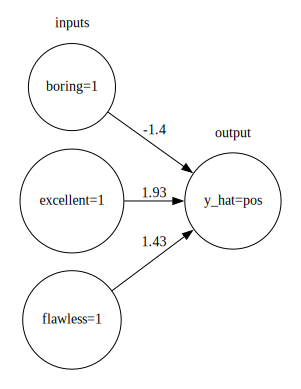

In [22]:
x = ["boring=1", "excellent=1", "flawless=1"]
w = [-1.40, 1.93, 1.43]
display(plot_logistic_regression(x, w))

- So the prediction is based on the weighted sum of the input features.
- Some feature are pulling the prediction towards positive sentiment and some are pulling it towards negative sentiment. 
- If the coefficient of _boring_ had a bigger magnitude or _excellent_ and _flawless_ had smaller magnitudes, we would have predicted "neg".   

In [23]:
def f(w_0):
    x = ["boring=1", "excellent=1", "flawless=1"]
    w = [-1.40, 1.93, 1.43]
    w[0] = w_0
    print(w)
    display(plot_logistic_regression(x, w))

[-1.4, 1.93, 1.43]
Weighted sum of the input features = 1.960 y_hat = pos


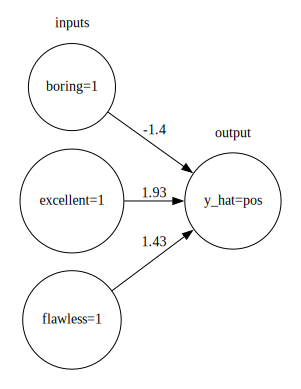

interactive(children=(FloatSlider(value=-1.4, description='w_0', max=2.0, min=-6.0, step=0.5), Output()), _dom…

In [24]:
interactive(
    f,
    w_0=widgets.FloatSlider(min=-6, max=2, step=0.5, value=-1.40),
)

In our case, for values for the coefficient of _boring_ < -3.36, the prediction would be negative. 

A linear model learns these coefficients or weights from the training data! 

So a linear classifier is a linear function of the input `X`, followed by a threshold. 

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots + w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

$$\hat{y} = \begin{cases}
         1, & \text{if } z \geq r\\
         -1, & \text{if } z < r
\end{cases}$$

#### Components of a linear classifier

1. input features ($x_1, \dots, x_d$)
2. coefficients (weights) ($w_1, \dots, w_d$)
3. bias ($b$ or $w_0$) (can be used to offset your hyperplane)
4. threshold ($r$)

In our example before, we assumed $r=0$ and $b=0$.

### Logistic regression on the cities data

In [25]:
cities_df = pd.read_csv("../data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]

train_df.head()

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada


Let's first try `DummyClassifier` on the cities data. 

In [26]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000731,0.002091,0.588235,0.601504
1,0.000507,0.000284,0.588235,0.601504
2,0.000539,0.000439,0.606061,0.597015
3,0.000497,0.000667,0.606061,0.597015
4,0.000748,0.000438,0.606061,0.597015


Now let's try `LogisticRegression`

In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
scores = cross_validate(lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.011472,0.001344,0.852941,0.827068
1,0.004912,0.001146,0.823529,0.827068
2,0.004917,0.001268,0.696970,0.858209
3,0.005290,0.001145,0.787879,0.843284
4,0.004687,0.001087,0.939394,0.805970


Logistic regression seems to be doing better than dummy classifier. But note that there is a lot of variation in the scores. 

### Accessing learned parameters

- Recall that logistic regression learns the weights $w$ and bias or intercept $b$.

- How to access these weights? 
    - Similar to `Ridge`, we can access the weights and intercept using `coef_` and `intercept_` attribute of the `LogisticRegression` object, respectively. 

In [28]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Model weights: %s" % (lr.coef_))  # these are the learned weights
print("Model intercept: %s" % (lr.intercept_))  # this is the bias term
data = {"features": X_train.columns, "coefficients": lr.coef_[0]}
pd.DataFrame(data)

Model weights: [[-0.04108149 -0.33683126]]
Model intercept: [10.8869838]


,features,coefficients
0,longitude,-0.041081
1,latitude,-0.336831


- Both negative weights 
- The weight of latitude is larger in magnitude. 
- This makes sense because Canada as a country lies above the USA and so we expect latitude values to contribute more to a prediction than longitude. 

### Prediction with learned parameters

Let's predict target of a test example. 

In [29]:
example = X_test.iloc[0, :]
example

longitude   -64.8001
latitude     46.0980
Name: 172, dtype: float64

#### Raw scores

- Calculate the raw score as: ```y_hat = np.dot(w, x) + b```

In [30]:
(
    np.dot(
        example.to_numpy(),
        lr.coef_.reshape(
            2,
        ),
    )
    + lr.intercept_
)

array([-1.97817876])

- Apply the threshold to the raw score. 
- Since the prediction is < 0, predict "negative". 
- What is a "negative" class in our context? 
- With logistic regression, the model randomly assigns one of the classes as a positive class and the other as negative. 
    - Usually it would alphabetically order the target and pick the first one as negative and second one as the positive class. 

- The `classes_` attribute tells us which class is considered negative and which one is considered positive. - In this case, Canada is the negative class and USA is a positive class. 

In [31]:
lr.classes_

array(['Canada', 'USA'], dtype=object)

- So based on the negative score above (-1.978), we would predict Canada. 
- Let's check the prediction given by the model. 

In [32]:
lr.predict([example])

array(['Canada'], dtype=object)

Great! The predictions match! We exactly know how the model is making predictions. 

### Decision boundary of logistic regression

- The decision boundary of logistic regression is a **hyperplane** dividing the feature space in half. 

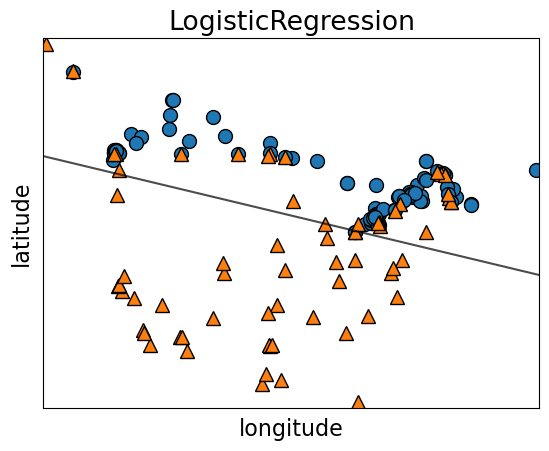

In [33]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train)
mglearn.plots.plot_2d_separator(lr, X_train.to_numpy(), fill=False, eps=0.5, alpha=0.7)
plt.title(lr.__class__.__name__)
plt.xlabel("longitude")
plt.ylabel("latitude");

- For $d=2$, the decision boundary is a line (1-dimensional)
- For $d=3$, the decision boundary is a plane (2-dimensional)
- For $d\gt 3$, the decision boundary is a $d-1$-dimensional hyperplane

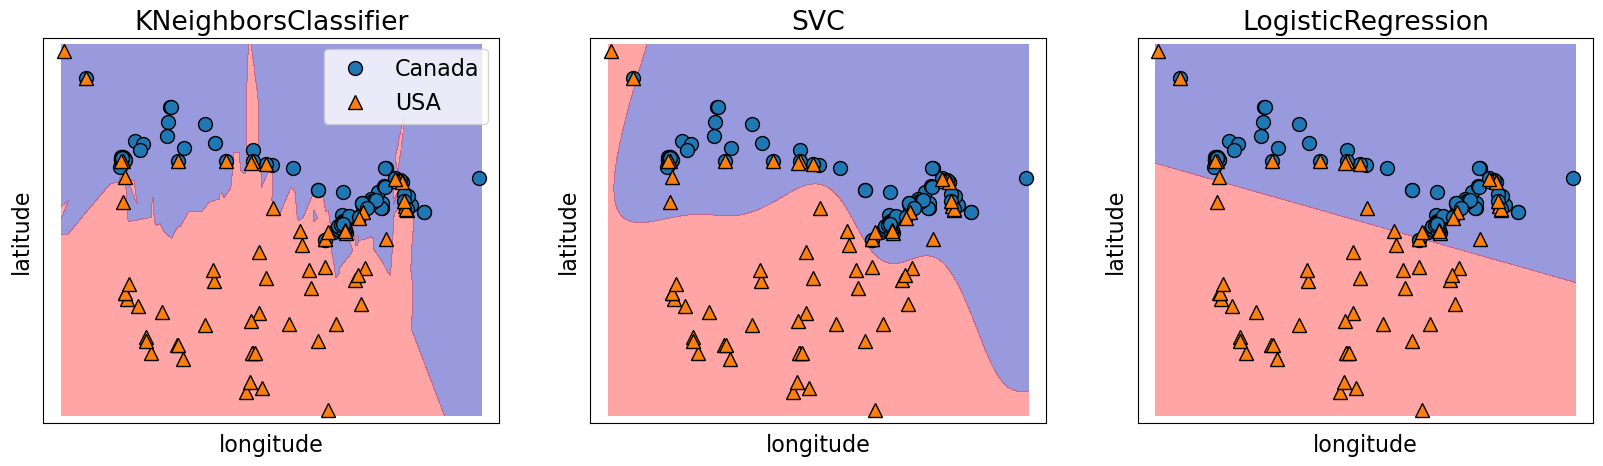

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for model, ax in zip(
    [KNeighborsClassifier(), SVC(gamma=0.01), LogisticRegression()], axes
):
    clf = model.fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(
        clf, X_train.to_numpy(), fill=True, eps=0.5, ax=ax, alpha=0.4
    )
    mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
axes[0].legend();

- Notice a linear decision boundary (a line in our case). 
- Compare it with  KNN or SVM RBF decision boundaries. 

### Main hyperparameter of logistic regression 

- `C` is the main hyperparameter which controls the fundamental trade-off.
- We won't really talk about the interpretation of this hyperparameter right now. 
- At a high level, the interpretation is similar to `C` of SVM RBF
    - smaller `C` $\rightarrow$ might lead to underfitting
    - bigger `C` $\rightarrow$ might lead to overfitting

In [35]:
scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    lr = LogisticRegression(C=C)
    scores = cross_validate(lr, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.0001,0.664707,0.658645
1,0.0010,0.784424,0.790731
2,0.0100,0.827842,0.826203
3,0.1000,0.832320,0.820143
4,1.0000,0.832320,0.820143
5,10.0000,0.832320,0.820143
6,100.0000,0.832320,0.820143
7,1000.0000,0.832320,0.820143
8,10000.0000,0.832320,0.820143
9,100000.0000,0.832320,0.820143


<br><br><br><br>

## Predicting probability scores [[video](https://youtu.be/_OAK5KiGLg0)]

### `predict_proba`

- So far in the context of classification problems, we focused on getting "hard" predictions. 
- Very often it's useful to know "soft" predictions, i.e., how confident the model is with a given prediction.  
- For most of the `scikit-learn` classification models we can access this confidence score or probability score using a method called `predict_proba`.  

Let's look at probability scores of logistic regression model for our test example. 

In [36]:
example

longitude   -64.8001
latitude     46.0980
Name: 172, dtype: float64

In [37]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict([example])  # hard prediction

array(['Canada'], dtype=object)

In [38]:
lr.predict_proba([example])  # soft prediction

array([[0.87848688, 0.12151312]])

- The output of `predict_proba` is the probability of each class. 
- In binary classification, we get probabilities associated with both classes (even though this information is redundant). 
- The first entry is the estimated probability of the first class and the second entry is the estimated probability of the second class from `model.classes_`. 

In [39]:
lr.classes_

array(['Canada', 'USA'], dtype=object)

- Because it's a probability, the sum of the entries for both classes should always sum to 1. 
- Since the probabilities for the two classes sum to 1, exactly one of the classes will have a score >=0.5, which is going to be our predicted class.  

#### How does logistic regression calculate these probabilities? 

- The weighted sum $w_1x_1 + \dots + w_dx_d + b$ gives us "raw model output".
- For linear regression this would have been the prediction.
- For logistic regression, you check the **sign** of this value.
  - If positive (or 0), predict $+1$; if negative, predict $-1$.
  - These are "hard predictions".

- You can also have "soft predictions", aka **predicted probabilities**. 
  - To convert the raw model output into probabilities, instead of taking the sign, we apply the **sigmoid**.

#### The sigmoid function 
- The sigmoid function "squashes" the raw model output from any number to the range $[0,1]$ using the following formula, where $x$ is the raw model output (y = a + bx)
$$\frac{1}{1+e^{-x}}$$
- Then we can interpret the output as probabilities.

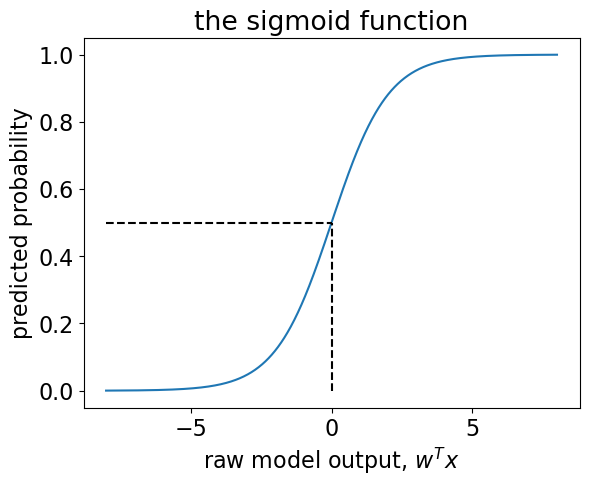

In [40]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
raw_model_output = np.linspace(-8, 8, 1000)
plt.plot(raw_model_output, sigmoid(raw_model_output))
plt.plot([0, 0], [0, 0.5], "--k")
plt.plot([-8, 0], [0.5, 0.5], "--k")
plt.xlabel("raw model output, $w^Tx$")
plt.ylabel("predicted probability")
plt.title("the sigmoid function");

- Recall our hard predictions that check the sign of $w^Tx$, or, in other words, whether or not it is $\geq 0$.
  - The threshold $w^Tx=0$ corresponds to $p=0.5$. 
  - In other words, if our predicted probability is $\geq 0.5$ then our hard prediction is $+1$.

Let's get the probability score by calling sigmoid on the raw model output for our test example.

In [41]:
sigmoid(
    np.dot(
        example.to_numpy(),
        lr.coef_.reshape(
            2,
        ),
    )
    + lr.intercept_
)

array([0.12151312])

This is the probability score of the positive class, which is USA. 

In [42]:
lr.predict_proba([example])

array([[0.87848688, 0.12151312]])

With `predict_proba`, we get the same probability score for USA!!

- Let's visualize probability scores for some examples. 

In [43]:
data_dict = {
    "y": y_train[:12],
    "y_hat": lr.predict(X_train[:12]).tolist(),
    "probabilities": lr.predict_proba(X_train[:12]).tolist(),
}

In [44]:
pd.DataFrame(data_dict)

,y,y_hat,probabilities
160,Canada,Canada,"[0.7046068097086481, 0.2953931902913519]"
127,Canada,Canada,"[0.563016906204013, 0.436983093795987]"
169,Canada,Canada,"[0.8389680973255864, 0.16103190267441364]"
188,Canada,Canada,"[0.7964150775404333, 0.20358492245956678]"
187,Canada,Canada,"[0.9010806652340972, 0.0989193347659027]"
192,Canada,Canada,"[0.7753006388010791, 0.2246993611989209]"
62,USA,USA,"[0.03074070460652778, 0.9692592953934722]"
141,Canada,Canada,"[0.6880304799160918, 0.3119695200839082]"
183,Canada,Canada,"[0.7891358587234145, 0.21086414127658554]"
37,USA,USA,"[0.006546969753885357, 0.9934530302461146]"


The actual `y` and `y_hat` match in most of the cases but in some cases the model is more confident about the prediction than others. 

#### Least confident cases 

Let's examine some cases where the model is least confident about the prediction. 

In [45]:
least_confident_X = X_train.loc[[127, 141]]
least_confident_X

,longitude,latitude
127,-81.2496,42.9837
141,-79.6902,44.3893


In [46]:
least_confident_y = y_train.loc[[127, 141]]
least_confident_y

127    Canada
141    Canada
Name: country, dtype: object

In [47]:
probs = lr.predict_proba(least_confident_X)

data_dict = {
    "y": least_confident_y,
    "y_hat": lr.predict(least_confident_X).tolist(),
    "probability score (Canada)": probs[:, 0],
    "probability score (USA)": probs[:, 1],
}
pd.DataFrame(data_dict)

,y,y_hat,probability score (Canada),probability score (USA)
127,Canada,Canada,0.563017,0.436983
141,Canada,Canada,0.688030,0.311970


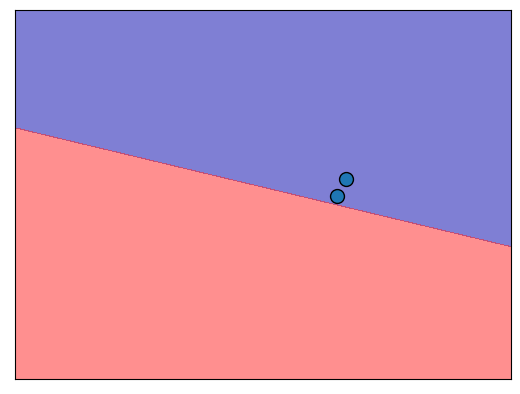

In [48]:
mglearn.discrete_scatter(
    least_confident_X.iloc[:, 0],
    least_confident_X.iloc[:, 1],
    least_confident_y,
    markers="o",
)
mglearn.plots.plot_2d_separator(lr, X_train.to_numpy(), fill=True, eps=0.5, alpha=0.5)

The points are close to the decision boundary which makes sense. 

#### Most confident cases 

Let's examine some cases where the model is most confident about the prediction. 

In [49]:
most_confident_X = X_train.loc[[37, 165]]
most_confident_X

,longitude,latitude
37,-98.4951,29.4246
165,-52.7151,47.5617


In [50]:
most_confident_y = y_train.loc[[37, 165]]
most_confident_y

37        USA
165    Canada
Name: country, dtype: object

In [51]:
probs = lr.predict_proba(most_confident_X)

data_dict = {
    "y": most_confident_y,
    "y_hat": lr.predict(most_confident_X).tolist(),
    "probability score (Canada)": probs[:, 0],
    "probability score (USA)": probs[:, 1],
}
pd.DataFrame(data_dict)

,y,y_hat,probability score (Canada),probability score (USA)
37,USA,USA,0.006547,0.993453
165,Canada,Canada,0.951092,0.048908


In [52]:
most_confident_X

,longitude,latitude
37,-98.4951,29.4246
165,-52.7151,47.5617


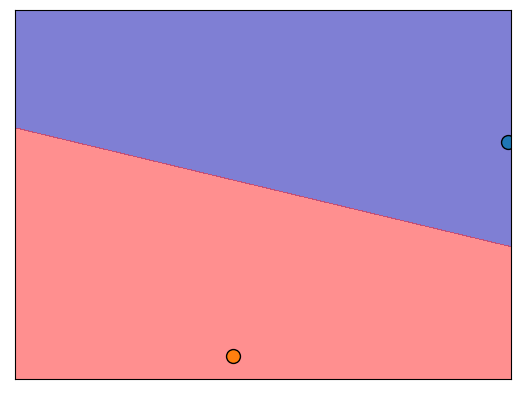

In [53]:
mglearn.discrete_scatter(
    most_confident_X.iloc[:, 0],
    most_confident_X.iloc[:, 1],
    most_confident_y,
    markers="o",
)
mglearn.plots.plot_2d_separator(lr, X_train.to_numpy(), fill=True, eps=0.5, alpha=0.5)

The points are far away from the decision boundary which makes sense. 

#### Over confident cases

Let's examine some cases where the model is confident about the prediction but the prediction is wrong. 

In [54]:
over_confident_X = X_train.loc[[0, 1]]
over_confident_X

,longitude,latitude
0,-130.0437,55.9773
1,-134.4197,58.3019


In [55]:
over_confident_y = y_train.loc[[0, 1]]
over_confident_y

0    USA
1    USA
Name: country, dtype: object

In [56]:
probs = lr.predict_proba(over_confident_X)

data_dict = {
    "y": over_confident_y,
    "y_hat": lr.predict(over_confident_X).tolist(),
    "probability score (Canada)": probs[:, 0],
    "probability score (USA)": probs[:, 1],
}
pd.DataFrame(data_dict)

,y,y_hat,probability score (Canada),probability score (USA)
0,USA,Canada,0.932487,0.067513
1,USA,Canada,0.961902,0.038098


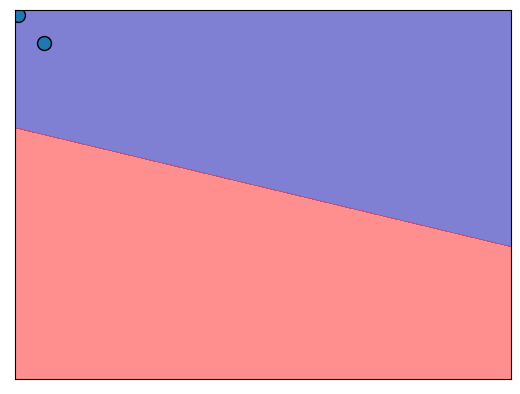

In [57]:
mglearn.discrete_scatter(
    over_confident_X.iloc[:, 0],
    over_confident_X.iloc[:, 1],
    over_confident_y,
    markers="o",
)
mglearn.plots.plot_2d_separator(lr, X_train.to_numpy(), fill=True, eps=0.5, alpha=0.5)

- The cities are far away from the decision boundary. So the model is pretty confident about the prediction. 
- But the cities are likely to be from Alaska and our linear model is not able to capture that this part belong to the USA and not Canada.

Below we are using colour to represent prediction probabilities. If you are closer to the border, the model is less confident whereas the model is more confident about the mainland cities, which makes sense.  

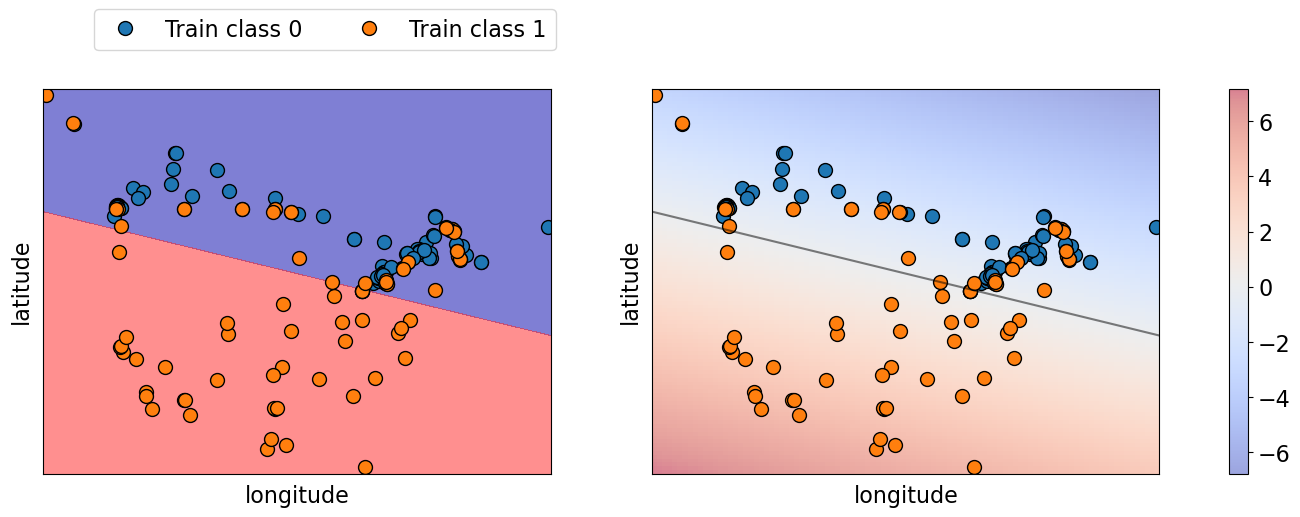

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
from matplotlib.colors import ListedColormap

for ax in axes:
    mglearn.discrete_scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, markers="o", ax=ax
    )
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")

axes[0].legend(["Train class 0", "Train class 1"], ncol=2, loc=(0.1, 1.1))

mglearn.plots.plot_2d_separator(
    lr, X_train.to_numpy(), fill=True, eps=0.5, ax=axes[0], alpha=0.5
)
mglearn.plots.plot_2d_separator(
    lr, X_train.to_numpy(), fill=False, eps=0.5, ax=axes[1], alpha=0.5
)
scores_image = mglearn.tools.plot_2d_scores(
    lr, X_train.to_numpy(), eps=0.5, ax=axes[1], alpha=0.5, cm=plt.cm.coolwarm
)
cbar = plt.colorbar(scores_image, ax=axes.tolist())

Sometimes a complex model that is overfitted, tends to make more confident predictions, even if they are wrong, whereas a simpler model tends to make predictions with more uncertainty. 

To summarize, 
- With hard predictions, we only know the class. 
- With probability scores we know how confident the model is with certain predictions, which can be useful in understanding the model better. 

### ❓❓ Questions for you

#### True/False 

- Increasing logistic regression's `C` hyperparameter increases model complexity. -> Yes  
- Unlike with `Ridge` regression, coefficients are not interpretable with logistic regression. -> No, still can interpret  
- The raw output score can be used to calculate the probability score for a given prediction. -> yes  
- For linear classifier trained on $d$ features, the decision boundary is a $d-1$-dimensional hyperparlane. -> Yes.  
- A linear model is likely to be uncertain about the data points close to the decision boundary. -> Yes   
- Similar to decision trees, conceptually logistic regression should be able to work with categorical features. -> Yes. As long as you have some way to convert categorical features into numerical ones (i.e ordinal or one hot encoding), there shouldn't be an issue with using Logistic Regression, since the model will simply learn coefficients for that encoded categorical feature.  
- Scaling might be a good idea in the context of logistic regression. -> Yes.  

#### More T/F (for practice)

1. The intercept of a linear model has a meaning similar to the model's coefficients (T/F) -> the intercept (often labeled the constant) is the expected mean value of Y when all X=0  
2. The snake weight linear model was trained on snakes between 0 and 200 cm of length. Should we try predicting the weight of a 250 cm long snake?
3. A positive coefficient indicates positive correlation between the feature and the target (T/F) -> True
4. RIDGE regression helps controlling the model complexity by limiting the number of non-zero coefficients in the model (T/F) 
5. Logistic regression only accepts binary inputs (T/F) -> False.
6. Changing the order of the classes in logistic regression will not affect the coefficients (T/F) -> True
7. A larger coefficient indicates a stronger correlation (T/F) -> True

### Linear SVM 

- We have seen non-linear SVM with RBF kernel before. This is the default SVC model in `sklearn` because it tends to work better in many cases. 
- There is also a linear SVM. You can pass `kernel="linear"` to create a linear SVM. 

In [59]:
cities_df = pd.read_csv("../data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]

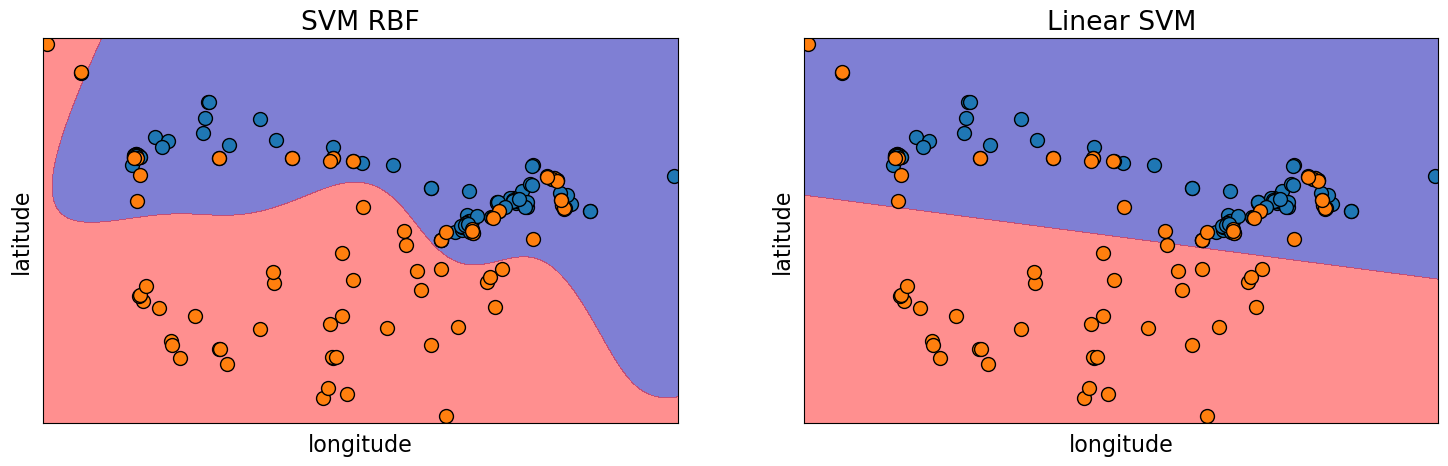

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
from matplotlib.colors import ListedColormap

for (model, ax) in zip([SVC(gamma=0.01), SVC(kernel="linear")], axes):
    mglearn.discrete_scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, markers="o", ax=ax
    )
    model.fit(X_train, y_train)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    mglearn.plots.plot_2d_separator(
        model, X_train.to_numpy(), fill=True, eps=0.5, ax=ax, alpha=0.5
    )

axes[0].set_title("SVM RBF")
axes[1].set_title("Linear SVM");

- `predict` method of linear SVM and logistic regression works the same way. 
- We can get `coef_` associated with the features and `intercept_` using a Linear SVM model. 

In [61]:
linear_svc = SVC(kernel="linear")
linear_svc.fit(X_train, y_train)
print("Model weights: %s" % (linear_svc.coef_))
print("Model intercept: %s" % (linear_svc.intercept_))

Model weights: [[-0.0195598  -0.23640124]]
Model intercept: [8.22811601]


In [62]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Model weights: %s" % (lr.coef_))
print("Model intercept: %s" % (lr.intercept_))

Model weights: [[-0.04108149 -0.33683126]]
Model intercept: [10.8869838]


- Note that the coefficients and intercept are slightly different for logistic regression. 
- This is because the `fit` for linear SVM and logistic regression are different. 

<br><br><br><br>

## Model interpretation of linear classifiers

- One of the primary advantage of linear classifiers is their ability to interpret models. 
- For example, with the sign and magnitude of learned coefficients we could answer questions such as which features are driving the prediction to which direction. 

- We'll demonstrate this by training `LogisticRegression` on the famous [IMDB movie review](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset. The dataset is a bit large for demonstration purposes. So I am going to put a big portion of it in the test split to speed things up. Every word is a feature, so every word gets a coefficient

In [68]:
imdb_df = pd.read_csv("../data/imdb_master.csv", encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df["sentiment"].str.startswith(("pos", "neg"))]
# imdb_df.drop(["Unnamed: 0", "type", "file"], axis=1, inplace=True)
imdb_df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


Let's clean up the data a bit. 

In [69]:
import re


def replace_tags(doc):
    doc = doc.replace("<br />", " ")
    doc = re.sub("https://\S*", "", doc)
    return doc

In [70]:
imdb_df["review_pp"] = imdb_df["review"].apply(replace_tags)

Are we breaking the Golden rule here? 

Let's split the data and create bag of words representation. 

In [72]:
train_df, test_df = train_test_split(imdb_df, test_size=0.9, random_state=123)
X_train, y_train = train_df["review_pp"], train_df["sentiment"]
X_test, y_test = test_df["review_pp"], test_df["sentiment"]
train_df.shape

(5000, 3)

In [73]:
vec = CountVectorizer(stop_words="english", max_features=10000)
bow = vec.fit_transform(X_train)
bow

<5000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 387967 stored elements in Compressed Sparse Row format>

### Examining the vocabulary

- The vocabulary (mapping from feature indices to actual words) can be obtained using `get_feature_names()` on the `CountVectorizer` object. 

In [74]:
vocab = vec.get_feature_names_out()

In [75]:
vocab[0:10]  # first few words

array(['00', '000', '007', '10', '100', '1000', '101', '11', '12', '13'],
      dtype=object)

In [76]:
vocab[2000:2010]  # some middle words

array(['constantly', 'constructed', 'construction', 'consumed',
       'consumption', 'contact', 'contacts', 'contain', 'contained',
       'containing'], dtype=object)

In [77]:
vocab[::500]  # words with a step of 500

array(['00', 'annoyance', 'billion', 'cbs', 'constantly', 'destroyed',
       'emotions', 'fired', 'greek', 'iconic', 'kathleen', 'madsen',
       'myers', 'path', 'psychic', 'ripped', 'sheriff', 'statues',
       'testing', 'vanity'], dtype=object)

### Model building on the dataset 

First let's try `DummyClassifier` on the dataset. 

In [78]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.009042,0.006595,0.504,0.50325
1,0.002718,0.002172,0.504,0.50325
2,0.003087,0.002005,0.503,0.50350
3,0.003829,0.002289,0.503,0.50350
4,0.002919,0.002075,0.503,0.50350


We have a balanced dataset. So the `DummyClassifier` score is around 0.5. 

Now let's try logistic regression. 

In [79]:
pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english", max_features=10000),
    LogisticRegression(max_iter=1000),
)
scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.857455,0.124633,0.833,0.99975
1,0.720016,0.122429,0.823,0.99975
2,0.752804,0.118949,0.841,0.99975
3,0.717958,0.117299,0.829,1.00000
4,0.766006,0.118581,0.843,0.99975


Seems like we are overfitting. Let's optimize the hyperparameter `C`. 

In [80]:
scores_dict = {
    "C": 10.0 ** np.arange(-3, 3, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    pipe_lr = make_pipeline(
        CountVectorizer(stop_words="english", max_features=10000),
        LogisticRegression(max_iter=1000, C=C),
    )
    scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.001,0.82625,0.7864
1,0.010,0.91765,0.8322
2,0.100,0.98570,0.8420
3,1.000,0.99980,0.8338
4,10.000,1.00000,0.8258
5,100.000,1.00000,0.8204


In [81]:
optimized_C = results_df["C"].iloc[np.argmax(results_df["mean_cv_scores"])]
print(
    "The maximum validation score is %0.3f at C = %0.2f "
    % (
        np.max(results_df["mean_cv_scores"]),
        optimized_C,
    )
)

The maximum validation score is 0.842 at C = 0.10 


Let's train a model on the full training set with the optimized hyperparameter values. 

In [82]:
pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english", max_features=10000),
    LogisticRegression(max_iter=1000, C=optimized_C),
)
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000, stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])

### Examining learned coefficients 

- The learned coefficients are exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 

In [83]:
feature_names = np.array(pipe_lr.named_steps["countvectorizer"].get_feature_names_out())
coeffs = pipe_lr.named_steps["logisticregression"].coef_.flatten()

In [84]:
word_coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
word_coeff_df

,Coefficient
00,0.059319
000,0.075304
007,0.005496
10,0.183887
100,-0.068119
...,...
zone,0.000364
zoo,-0.070315
zorro,0.042070
zu,0.072199


- Let's sort the coefficients in descending order. 
- Interpretation
    - if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$. 
    - if $w_j < 0$ then increasing $x_{ij}$ moves us toward predicting $-1$. 


In [85]:
word_coeff_df.sort_values(by="Coefficient", ascending=False)

,Coefficient
excellent,0.793580
amazing,0.620300
perfect,0.608056
wonderful,0.571926
great,0.535752
...,...
waste,-0.683318
terrible,-0.719764
boring,-0.724847
awful,-0.871614


- The coefficients make sense!

Let's visualize the top 10 features.

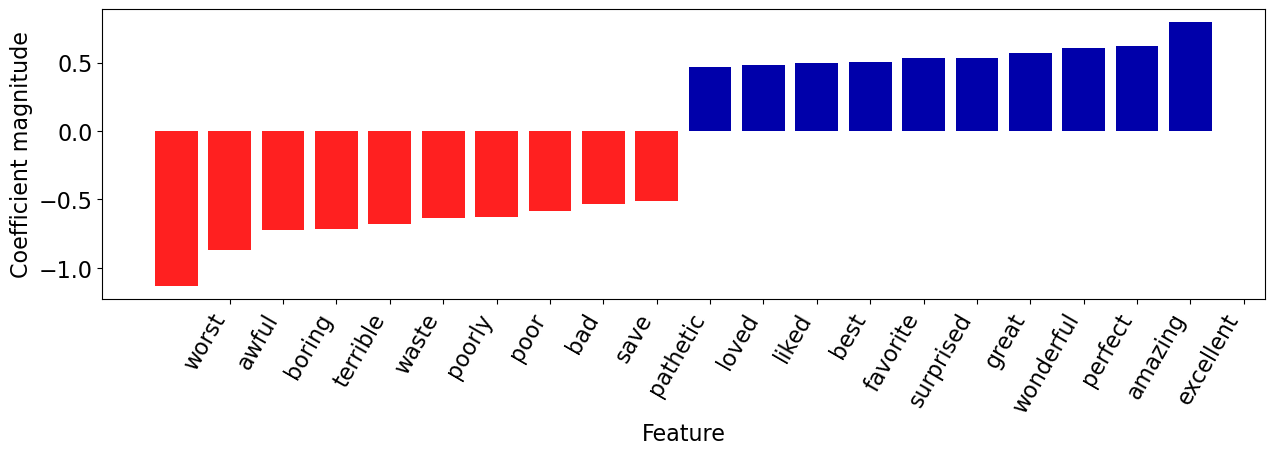

In [86]:
mglearn.tools.visualize_coefficients(coeffs, feature_names, n_top_features=10)

Let's explore prediction of the following new review. 

In [87]:
fake_review = "It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recomment it!"

In [88]:
feat_vec = pipe_lr.named_steps["countvectorizer"].transform([fake_review])

In [89]:
feat_vec

<1x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

Let's get prediction probability scores of the fake review. 

In [90]:
pipe_lr.predict_proba([fake_review])

array([[0.19954548, 0.80045452]])

The model is 82% confident that it's a positive review. 

In [91]:
pipe_lr.predict([fake_review])[0]

'positive'

We can find which of the vocabulary words are present in this review:

In [92]:
feat_vec.toarray().ravel().astype(bool)

array([False, False, False, ..., False, False, False])

In [93]:
words_in_ex = feat_vec.toarray().ravel().astype(bool)
words_in_ex

array([False, False, False, ..., False, False, False])

How many of the words are in this review?

In [94]:
np.sum(words_in_ex)

12

In [95]:
np.array(feature_names)[words_in_ex]

array(['acting', 'bit', 'boring', 'direction', 'enjoyed', 'excellent',
       'flawless', 'got', 'highly', 'movie', 'overall', 'times'],
      dtype=object)

In [96]:
ex_df = pd.DataFrame(
    data=coeffs[words_in_ex],
    index=np.array(feature_names)[words_in_ex],
    columns=["Coefficient"],
)
ex_df

,Coefficient
acting,-0.195029
bit,0.327265
boring,-0.724847
direction,-0.138359
enjoyed,0.416523
excellent,0.793580
flawless,0.066534
got,-0.087726
highly,0.328111
movie,-0.033038


Let's visualize how the words with positive and negative coefficients are driving the hard prediction. 

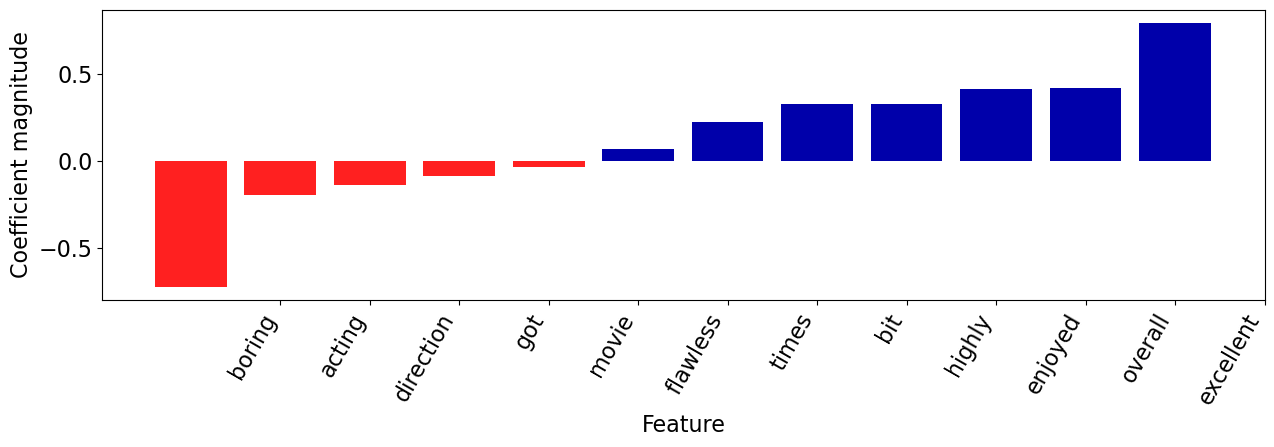

In [97]:
mglearn.tools.visualize_coefficients(
    coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=6
)

In [98]:
def plot_coeff_example(feat_vect, coeffs, feature_names):
    words_in_ex = feat_vec.toarray().ravel().astype(bool)

    ex_df = pd.DataFrame(
        data=coeffs[words_in_ex],
        index=np.array(feature_names)[words_in_ex],
        columns=["Coefficient"],
    )
    return ex_df

### Most positive review 

- Remember that you can look at the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method.
- Can we find the messages where our classifier is most confident or least confident?

In [99]:
pos_probs = pipe_lr.predict_proba(X_train)[
    :, 1
]  # only get probabilities associated with pos class
pos_probs

array([0.9757961 , 0.27491792, 0.93386022, ..., 0.7532728 , 0.87595562,
       0.00631911])

Let's get the index of the example where the classifier is most confident (highest `predict_proba` score for positive). 

In [100]:
most_positive = np.argmax(pos_probs)

In [101]:
X_train.iloc[most_positive]

'This is an awesome Amicus horror anthology, with 3 great stories, and fantastic performances!, only the last story disappoints. All the characters are awesome, and the film is quite chilling and suspenseful, plus Peter Cushing and Christopher Lee are simply amazing in this!. It\'s very underrated and my favorite story has to be the 3rd one "Sweets To The Sweet", plus all the characters are very likable. Some of it\'s predictable, and the last story was incredibly disappointing and rather bland!, however the ending was really cool!. This is an awesome Amicus horror anthology, with 3 great stories, and fantastic performances, only the last story disappoints!, i say it\'s must see!.  1st Story ("Method for Murder"). This is an awesome story, with plenty of suspense, and the killer Dominic is really creepy, and it\'s very well acted as well!. This was the perfect way to start off with a story, and for the most part it\'s unpredictable, plus the double twist ending is shocking, and quite c

In [102]:
print("True target: %s\n" % (y_train.iloc[most_positive]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_positive]])[0]))
print("Prediction probability: %0.4f" % (pos_probs[most_positive]))

True target: positive

Predicted target: positive

Prediction probability: 1.0000


Let's examine the features associated with the review. 

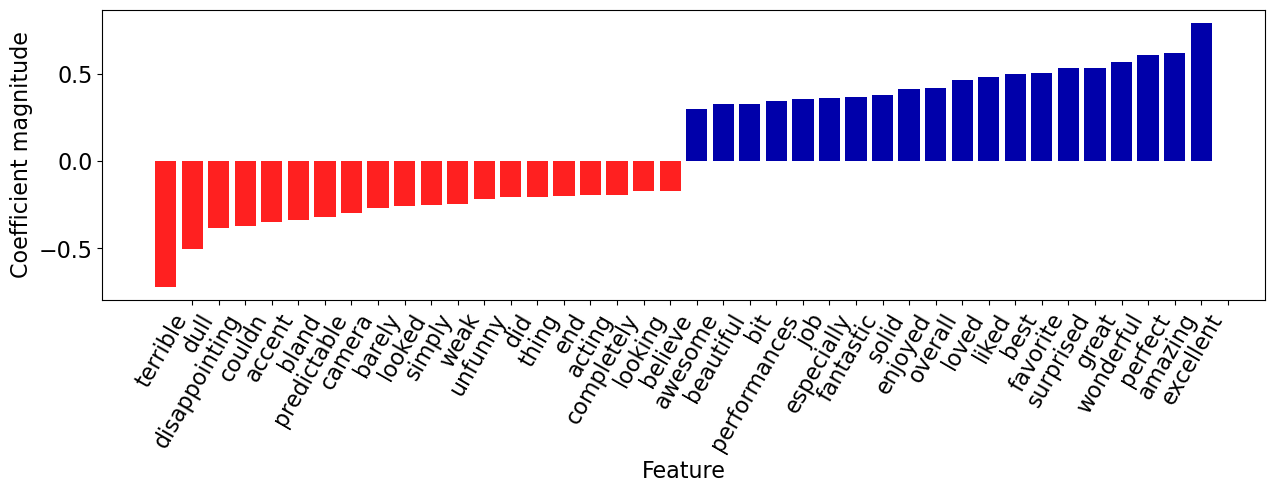

In [103]:
feat_vec = pipe_lr.named_steps["countvectorizer"].transform(
    X_train.iloc[[most_positive]]
)
words_in_ex = feat_vec.toarray().ravel().astype(bool)
mglearn.tools.visualize_coefficients(
    coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=20
)

The review has both positive and negative words but the words with **positive** coefficients win in this case! 

### Most negative review 

In [104]:
neg_probs = pipe_lr.predict_proba(X_train)[
    :, 0
]  # only get probabilities associated with pos class
neg_probs

array([0.0242039 , 0.72508208, 0.06613978, ..., 0.2467272 , 0.12404438,
       0.99368089])

In [105]:
most_negative = np.argmax(neg_probs)

In [106]:
print("Review: %s\n" % (X_train.iloc[[most_negative]]))
print("True target: %s\n" % (y_train.iloc[most_negative]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_negative]])[0]))
print("Prediction probability: %0.4f" % (pos_probs[most_negative]))

Review: 13452    Zombi 3 starts as a group of heavily armed men steal a experimental chemical developed to reanimate the dead, while trying to escape the man is shot at & the metal container holding the chemical i...
Name: review_pp, dtype: object

True target: negative

Predicted target: negative

Prediction probability: 0.0000


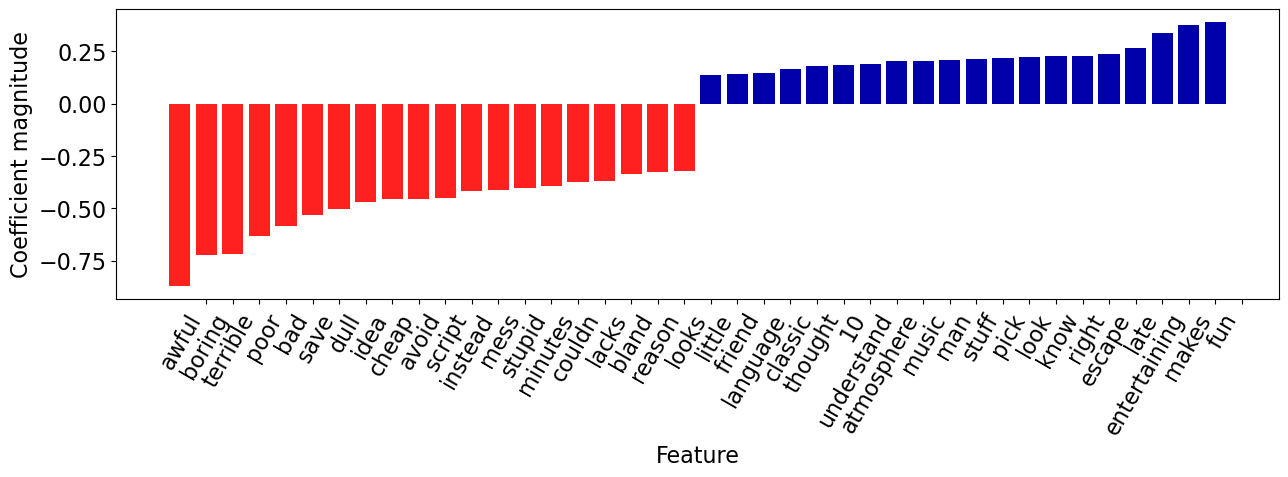

In [107]:
feat_vec = pipe_lr.named_steps["countvectorizer"].transform(
    X_train.iloc[[most_negative]]
)
words_in_ex = feat_vec.toarray().ravel().astype(bool)
mglearn.tools.visualize_coefficients(
    coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=20
)

The review has both positive and negative words but the words with negative coefficients win in this case! 

### ❓❓ Questions for you

#### Question for you to ponder on 

- Is it possible to identify most important features using $k$-NNs? What about decision trees?  


<br><br><br><br>

## Summary of linear models 

- Linear regression is a linear model for regression whereas logistic regression is a linear model for classification. 
- Both these models learn one coefficient per feature, plus an intercept. 

### Main hyperparameters 
- The main hyperparameter is the "regularization" hyperparameter controlling the fundamental tradeoff. 
    - Logistic Regression: `C`
    - Linear SVM: `C` 
    - Ridge: `alpha`

### Interpretation of coefficients in linear models 
- the $j$th coefficient tells us how feature $j$ affects the prediction
- if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$
- if $w_j < 0$ then increasing $x_{ij}$ moves us toward prediction $-1$
- if $w_j == 0$ then the feature is not used in making a prediction

### Strengths of linear models 

- Fast to train and predict
- Scale to large datasets and work well with sparse data 
- Relatively easy to understand and interpret the predictions
- Perform well when there is a large number of features 

### Limitations of linear models 

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with 0 error. 
    - If the training examples can be separated by a linear decision rule, they are **linearly separable**.



A few questions you might be thinking about
- How often the real-life data is linearly separable?
- Is the following XOR function linearly separable?  

| $$x_1$$ | $$x_2$$ | target|
|---------|---------|---------|
| 0 | 0  | 0|
| 0 | 1  | 1|
| 1 | 0  | 1|
| 1 | 1  | 0|    

- Are linear classifiers very limiting because of this?     

<be><br><br><br>